In [1]:
from glob import glob
from xml.etree import ElementTree as ET
from matplotlib import pyplot as plt
from fastai.vision import *
from utils import *
from detection_network import *
from shutil import copy as sh_copy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
xml_list = sorted(glob('DLAssignment/*.xml'))
img_list = sorted(glob('DLAssignment/*.jpg'))

In [4]:
img_list[10], xml_list[10]

('DLAssignment/14.jpg', 'DLAssignment/14.xml')

In [5]:
def get_parsed_bbox(pvoc_file):
    tree = ET.parse(pvoc_file)
    root = tree.getroot()
    bbox_list, categories = [], []
    has_rotated_comp = False
    for obj in root.iter('object'):
        is_rotated_obj = False
        if (obj.find("rotated").text) == '1':
            is_rotated_obj = True
        box = obj.findall("bndbox")[0]
        xmin = int(box.find("xmin").text)
        ymin = int(box.find("ymin").text)
        xmax = int(box.find("xmax").text)
        ymax = int(box.find("ymax").text)
        an_obj_bbox = [ymin, xmin, ymax, xmax]
        bbox_list.append(an_obj_bbox)
        name = obj.find('name').text
        categories.append(name)
        if is_rotated_obj: 
            has_rotated_comp=True
            name = name+"_rotated"
            bbox_list.append(an_obj_bbox)
            categories.append(name)
    return bbox_list, categories, has_rotated_comp


def get_img_nd_lbl_bboxes(img_list, pvoc_list, ovr_smpl_rate=3):
    imgs, lbl_bbox = [], []
    rot_img_lst = []
    data_path_list = zip(img_list, pvoc_list)
    for img_path, pascal_voc_path in data_path_list:
        bbox_list, categories, has_rotated_comp = get_parsed_bbox(pascal_voc_path)
        imgs.append(img_path)
        lbl_bbox.append([bbox_list,categories])

        if has_rotated_comp:     
            rot_img_lst.append(img_path)
            for i in range(ovr_smpl_rate):
                file_name = os.path.basename(img_path)
                new_img_path = img_path.replace(file_name, str(i)+'_'+file_name)
                new_img_path = sh_copy(img_path, new_img_path)
                imgs.append(new_img_path)
                lbl_bbox.append([bbox_list,categories])
    return imgs, lbl_bbox, rot_img_lst

In [6]:
## Cleanup before Oversampling, if there are any previously oversampled images
# Since we have only oversampled images 3 times, then we will have oversampled images with 
# filename starting with either of [0,1,2] followed by the underscore

!find ./DLAssignment/ -maxdepth 1 -type f -name "*[0,1,2]_*.jpg" -print0 | xargs -0 rm 2> /dev/null

In [7]:
imgs, lbl_bbox, rotated_imgs_list = get_img_nd_lbl_bboxes(img_list, xml_list)

In [8]:
# Sanity checking for rotated component
idx = 13
[obj for obj in get_parsed_bbox(rotated_imgs_list[idx].replace('jpg','xml'))[1] if 'rotated' in obj]

['27_x_rotated', '45_i_rotated']

In [10]:
imgs = [img.split('/')[-1] for img in imgs]

In [12]:
img2bbox = dict(zip(imgs, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [13]:
path = Path('/home/ubuntu/bmk_work/nnets/')

In [14]:
#  Removing all the default agumentation transformations except zoom and lightning because 
#  we get similar images in the same orientation
tfms = get_transforms(do_flip = False, 
        flip_vert = False,
        max_rotate = 0,
        max_zoom = 1.15,
        max_lighting= 0.2,
        max_warp= 0,
        p_affine = 0.50,
        p_lighting = 0.30)

In [ ]:
# Copy all the images to a seperate folder to enable it to load cleanly

# !rm -rf imgs 2> /dev/null
# !mkdir imgs
# !find DLAssignment/ -maxdepth 1 -type f -name "*.jpg" -print0 | xargs -0 cp -t imgs

In [16]:
# Create the DataBunch to train the model
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'imgs')
    src = src.split_by_rand_pct(valid_pct=0.15)
    src = src.label_from_func(get_y_func)
    src = src.transform(tfms, size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [17]:
# Taking less batch size so that the model can have more updations while backpropagation

bs=16
size=256
data = get_data(bs,size)

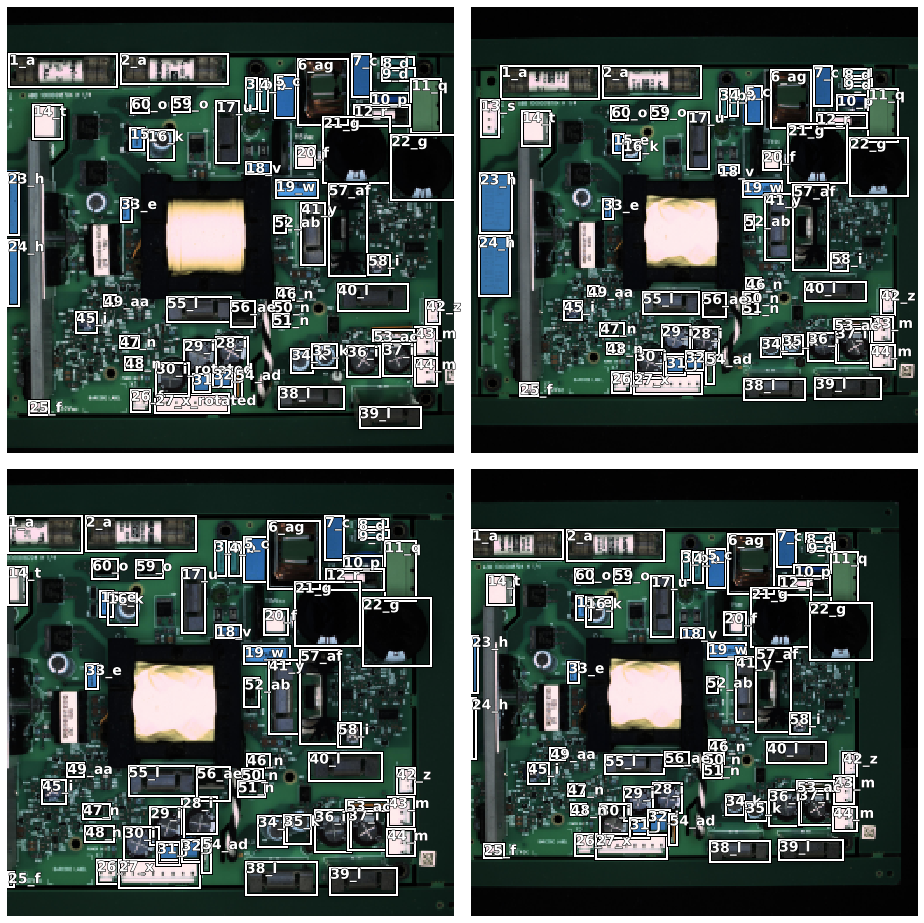

In [18]:
#Quick over view of data

data.show_batch(rows=2,figsize=(13,13))

In [19]:
# From the RetinaNet Paper 
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
#scales = [1,2**(1/3), 2**(2/3)] for bigger size

In [20]:
encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

In [21]:
def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

In [22]:
learn = learn.split(retina_net_split)

In [23]:
learn.freeze()

In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,3.628292,#na#,00:15
1,3.626787,#na#,00:11
2,3.622099,#na#,00:11
3,3.607815,#na#,00:10
4,3.551719,#na#,00:10
5,3.464212,#na#,00:11
6,3.316271,#na#,00:11
7,3.235984,#na#,00:10
8,3.340217,#na#,00:11
9,4.827730,#na#,00:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-05
Min loss divided by 10: 3.98E-05


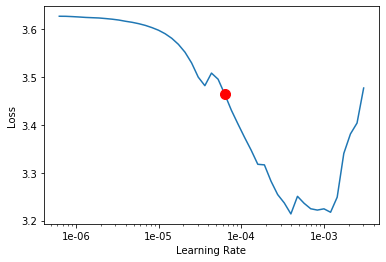

In [25]:
learn.recorder.plot(skip_end=5,suggestion=True)

In [26]:
learn.fit_one_cycle(5, 6e-5)

epoch,train_loss,valid_loss,time
0,3.586082,3.385491,00:20
1,3.317708,2.581323,00:18
2,3.042146,2.418480,00:18
3,2.846707,2.279459,00:18
4,2.710443,2.251023,00:19


In [27]:
learn.save('stage1_256_3')

In [28]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,time
0,2.318238,#na#,00:11
1,2.310482,#na#,00:11
2,2.289488,#na#,00:11
3,2.271673,#na#,00:11
4,2.226801,#na#,00:11
5,2.136900,#na#,00:11
6,1.994037,#na#,00:11
7,2.086029,#na#,00:11
8,2.287296,#na#,00:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 1.91E-05


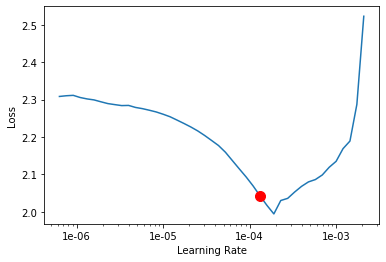

In [29]:
learn.recorder.plot(suggestion=True)

In [30]:
learn.fit_one_cycle(25, slice(5e-5, 4.8e-4))

epoch,train_loss,valid_loss,time
0,2.261645,2.053247,00:18
1,2.089255,1.596814,00:18
2,1.876675,1.320201,00:18
3,1.701341,1.120603,00:18
4,1.543720,0.829527,00:18
5,1.459905,1.294878,00:18
6,1.416604,0.764971,00:18
7,1.301454,0.634079,00:18
8,1.189270,0.441562,00:18
9,1.077226,0.336658,00:18


In [31]:
learn.save('stage2_256_3')

In [32]:
learn = learn.load('stage2_256_3')

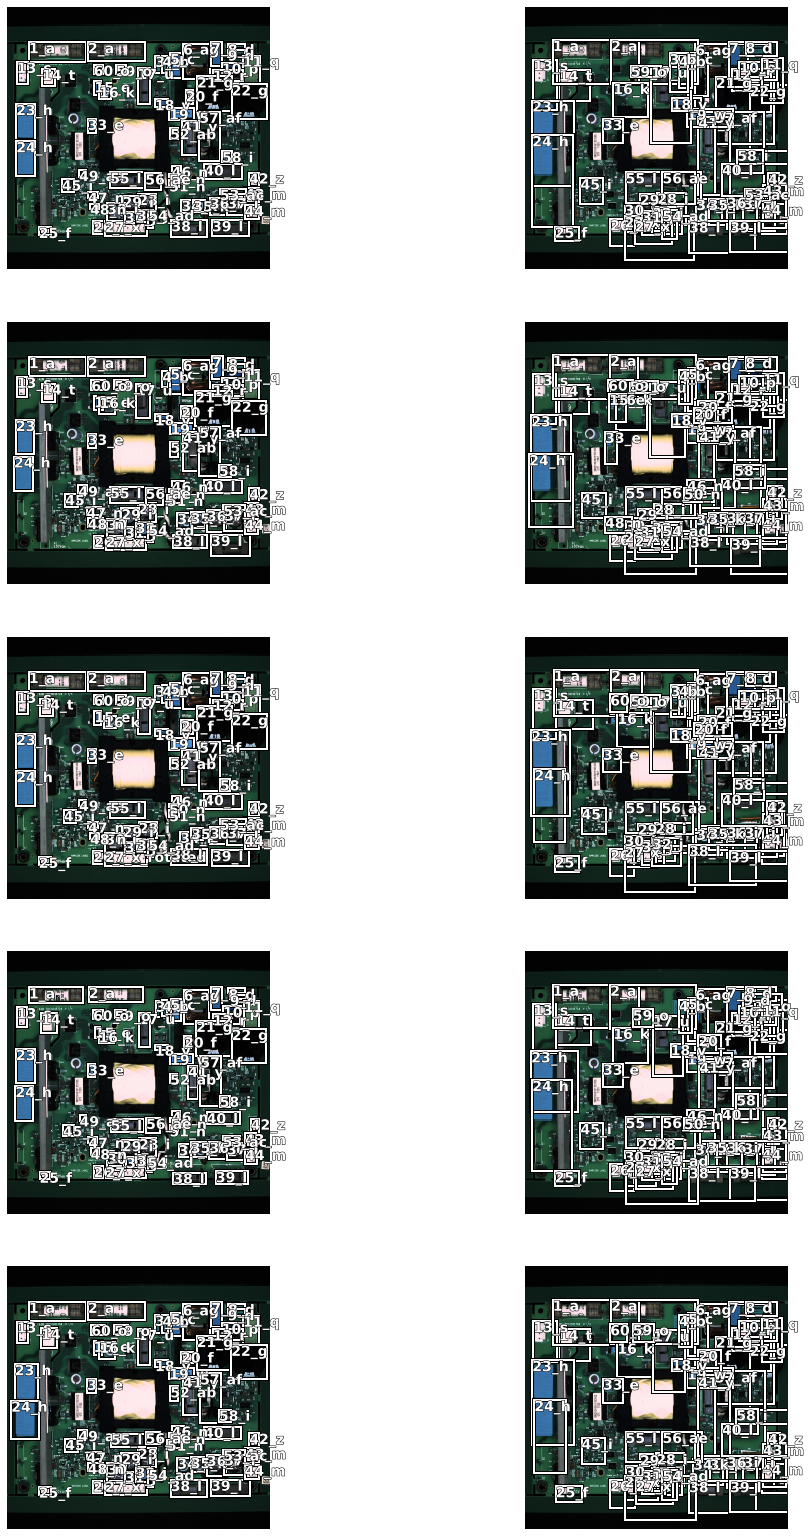

In [33]:
show_results(learn, start=8, detect_thresh=0.65,figsize=(17, 28))

In [34]:
L = compute_class_AP(learn.model, data.valid_dl, data.c-1)

In [35]:
aps = []
for ap,cl in zip(L, data.classes[1:]): 
    aps.append(ap)

In [36]:
import seaborn as sns

In [37]:
mAP_df = pd.DataFrame([data.classes[1:],L]).T

In [38]:
mAP_df.columns = ['classes', 'AP']

In [39]:
mAP_df.sort_values(by='AP',ascending=False,inplace=True)

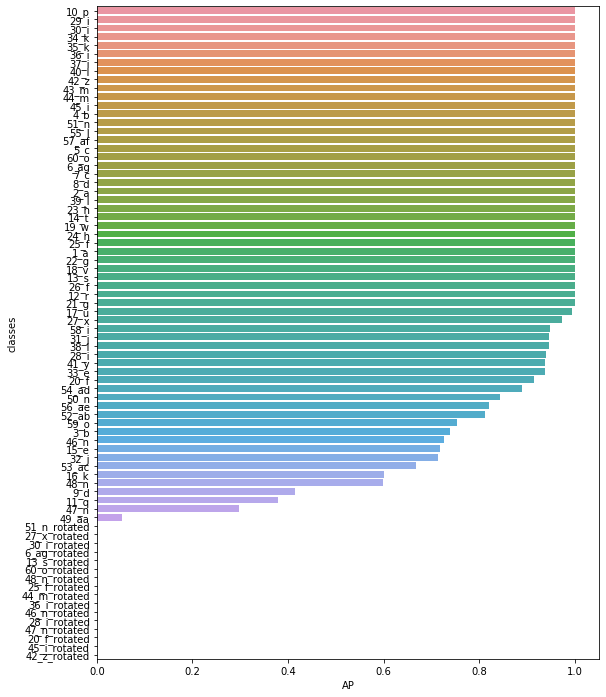

In [40]:
fig, ax = plt.subplots(figsize=(9,12))
sns.barplot(mAP_df.AP, mAP_df.classes,ax=ax)
plt.show()

In [41]:
mAP = np.mean(aps)

In [43]:
print(mAP)

0.7046255363961548


In [44]:
learn.export('pcb_msng_and_rotd.pkl')

In [47]:
print(data.train_ds.classes)

['background', '10_p', '11_q', '12_r', '13_s', '13_s_rotated', '14_t', '15_e', '16_k', '17_u', '18_v', '19_w', '1_a', '20_f', '20_f_rotated', '21_g', '22_g', '23_h', '24_h', '25_f', '25_f_rotated', '26_f', '27_x', '27_x_rotated', '28_i', '28_i_rotated', '29_i', '2_a', '30_i', '30_i_rotated', '31_j', '32_j', '33_e', '34_k', '35_k', '36_i', '36_i_rotated', '37_i', '38_l', '39_l', '3_b', '40_l', '41_y', '42_z', '42_z_rotated', '43_m', '44_m', '44_m_rotated', '45_i', '45_i_rotated', '46_n', '46_n_rotated', '47_n', '47_n_rotated', '48_n', '48_n_rotated', '49_aa', '4_b', '50_n', '51_n', '51_n_rotated', '52_ab', '53_ac', '54_ad', '55_l', '56_ae', '57_af', '58_i', '59_o', '5_c', '60_o', '60_o_rotated', '6_ag', '6_ag_rotated', '7_c', '8_d', '9_d']


In [57]:
idx = 5
print(rotated_imgs_list[idx])
[obj for obj in get_parsed_bbox(rotated_imgs_list[idx].replace('jpg','xml'))[1] if 'rotated' in obj]

DLAssignment/24.24.jpg


['27_x_rotated']